1) Source of the dataset - Kaggle
  Dataset contains comments/text for which we need to train our model to find the toxicity in the text.
2) The goal in this analysis is to train our model to read the comments/text and determine the toxicity of the text. This will help us to categorize the user's comments into threats,insults, discrimination etc.

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv', index_col = 'id')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv', index_col = 'id')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [ ]:
train_df.shape

(1804874, 44)

In [ ]:
train_df = train_df.sample(frac=0.01)
test_df = test_df.sample(frac=0.01)

In [ ]:
test_df.shape

(973, 1)

In [ ]:
#EXPLORATORY DATA ANALYSIS
#Checking the missing values :

In [ ]:
train_df.isna().sum()

target                                     0
comment_text                               0
severe_toxicity                            0
obscene                                    0
identity_attack                            0
insult                                     0
threat                                     0
asian                                  14066
atheist                                14066
bisexual                               14066
black                                  14066
buddhist                               14066
christian                              14066
female                                 14066
heterosexual                           14066
hindu                                  14066
homosexual_gay_or_lesbian              14066
intellectual_or_learning_disability    14066
jewish                                 14066
latino                                 14066
male                                   14066
muslim                                 14066
other_disa

In [ ]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,18049.000000,18049.000000,18049.000000,18049.000000,18049.000000,18049.000000,3983.000000,3983.000000,3983.000000,3983.000000,...,1.030400e+04,18049.000000,18049.000000,18049.000000,18049.000000,18049.000000,18049.000000,18049.000000,18049.000000,18049.000000
mean,0.103778,0.004450,0.013883,0.022649,0.082579,0.009101,0.011811,0.003025,0.001291,0.036203,...,3.733241e+06,280947.936008,0.278353,0.045155,0.106654,2.531830,0.620367,0.006376,1.387334,8.636933
std,0.199824,0.022328,0.063808,0.078342,0.179195,0.048564,0.083128,0.048668,0.018574,0.171668,...,2.450398e+06,104161.729474,1.057824,0.239842,0.448703,4.874056,1.953765,0.044378,15.008754,38.953576
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.396260e+05,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.090330e+05,160125.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.223224e+06,331985.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000
75%,0.166667,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.790994e+06,366603.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,6.000000
max,1.000000,0.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.700000,1.000000,...,6.332474e+06,399528.000000,37.000000,4.000000,17.000000,147.000000,73.000000,0.963624,1562.000000,1851.000000


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18049 entries, 269357 to 1038657
Data columns (total 44 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   target                               18049 non-null  float64
 1   comment_text                         18049 non-null  object 
 2   severe_toxicity                      18049 non-null  float64
 3   obscene                              18049 non-null  float64
 4   identity_attack                      18049 non-null  float64
 5   insult                               18049 non-null  float64
 6   threat                               18049 non-null  float64
 7   asian                                3983 non-null   float64
 8   atheist                              3983 non-null   float64
 9   bisexual                             3983 non-null   float64
 10  black                                3983 non-null   float64
 11  buddhist             

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


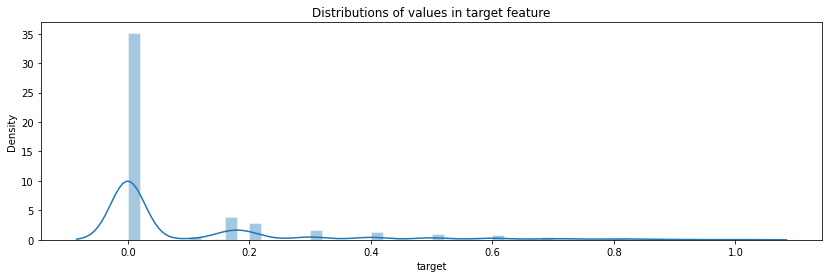

In [ ]:
plt.figure(figsize= (14, 4))
plt.title("Distributions of values in target feature")
sns.set_theme(color_codes= True)
feature = train_df['target']
sns.distplot(train_df['target'] , label = feature )
plt.show()

In [ ]:
#Detecting the outliers

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


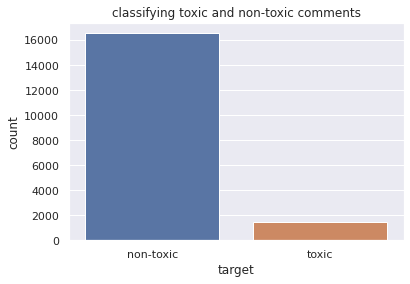

In [ ]:
t_cat = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")
temp=[]
plt.title('classifying toxic and non-toxic comments')
sns.countplot(t_cat)
plt.show()

**Here we have large number of non toxic comments compared to toxic comments and the data set is imbalanced**

**Now we have the nature of the toxicity**
* severe_toxicity
* obscene
* insult
* threat
* identity_attack

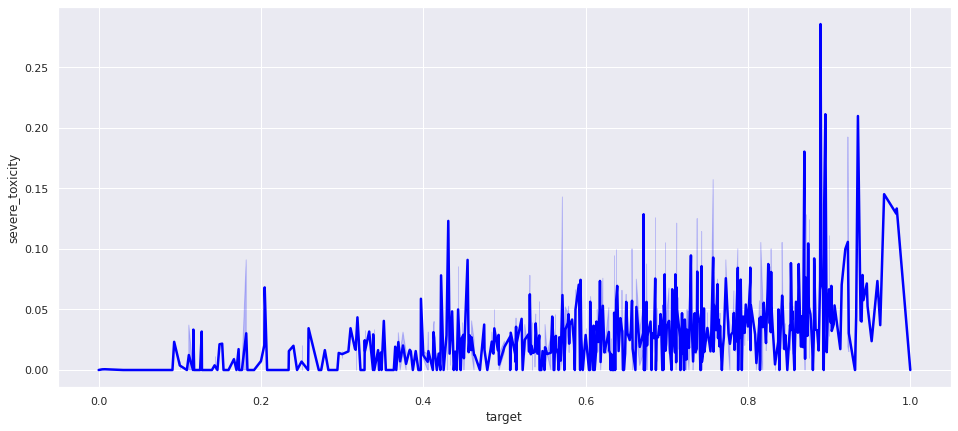

In [ ]:
plt.figure(figsize= (16,7))
sns.set_style()
ax = sns.lineplot(x= train_df['target'], y=train_df["severe_toxicity"] , color = 'blue' , linewidth = 2.5)
plt.show()

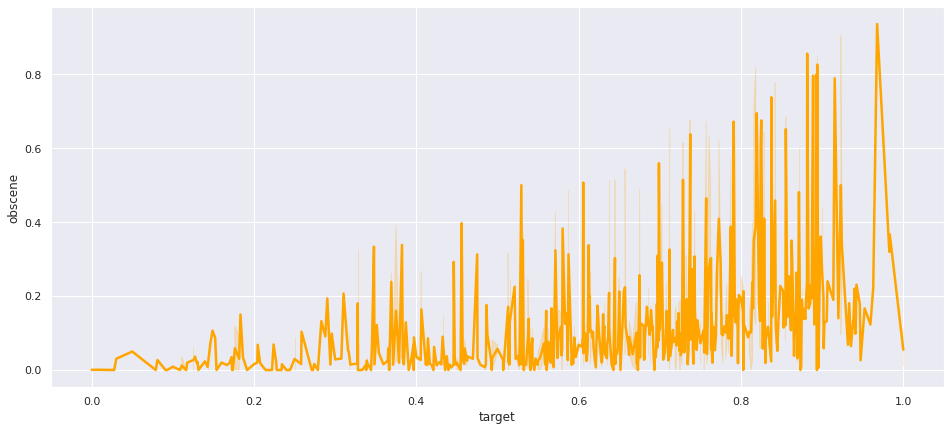

In [ ]:
plt.figure(figsize= (16,7))
sns.set_style()
sns.lineplot(x=train_df["target"], y=train_df["obscene"] , color = 'orange' , linewidth = 2.5)
plt.show()

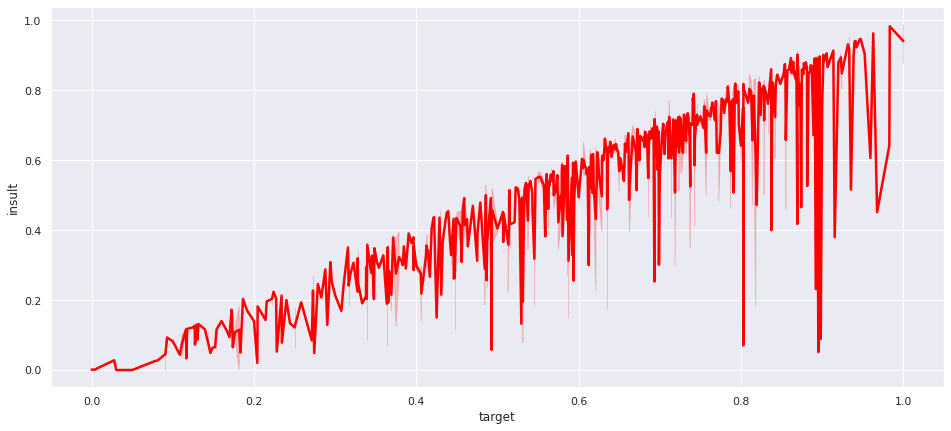

In [ ]:
plt.figure(figsize= (16,7))
sns.set_style()
sns.lineplot(x=train_df["target"], y=train_df["insult"] , color = 'red' , linewidth = 2.5)
plt.show()

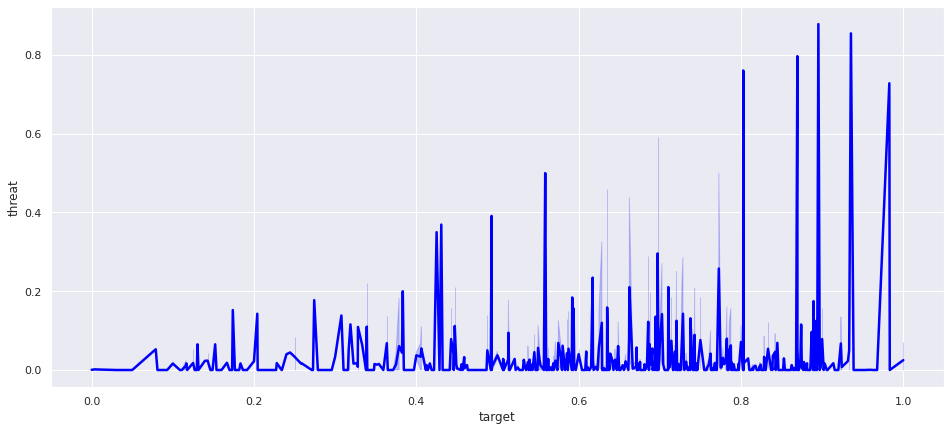

In [ ]:
plt.figure(figsize= (16,7))
sns.set_style()
sns.lineplot(x=train_df["target"], y=train_df["threat"] , color = 'blue' , linewidth = 2.5)
plt.show()

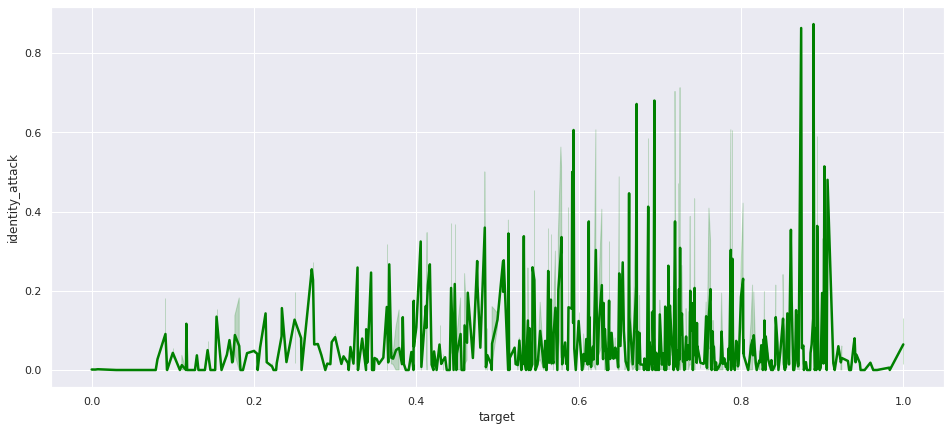

In [ ]:
plt.figure(figsize= (16,7))
sns.set_style()
sns.lineplot(x=train_df["target"], y=train_df["identity_attack"] , color = 'green' , linewidth = 2.5)
plt.show()

In [ ]:
def toxic_nature_distributions(dataframe, features, title):
  plt.figure(figsize=(12,6))
  plt.title(title)
  for feature in features:
    sns.distplot( dataframe[feature], kde = True, hist = False, bins = 240, label = feature )
  plt.xlabel('')
  plt.legend()
  plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

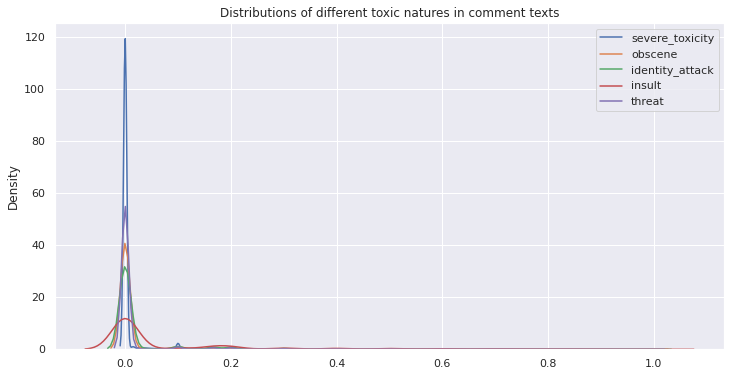

In [ ]:
##distributions of toxic nature columns

features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
toxic_nature_distributions(train_df , features, 'Distributions of different toxic natures in comment texts')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

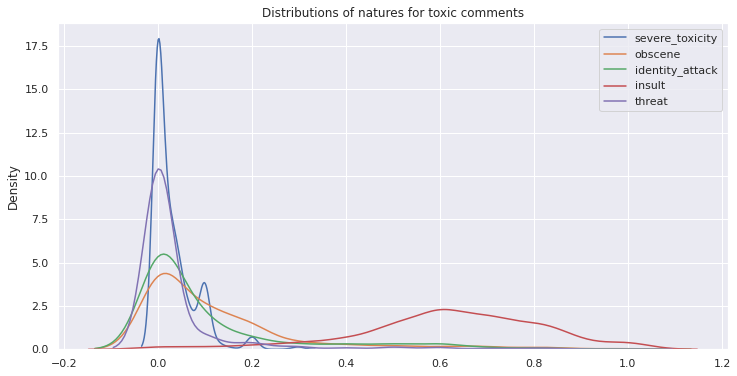

In [ ]:
## distributions of toxic nature columns which are considered toxic (target > 0.5)
toxic_comments = train_df[train_df['target'] > 0.5]
toxic_nature_distributions(toxic_comments , features, 'Distributions of natures for toxic comments')

Here we see that most of the toxic comments have insult in nature. We can also say that there are more insulting comments

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

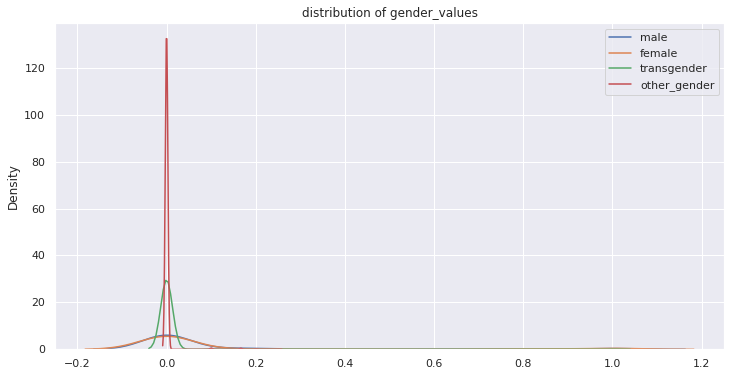

In [ ]:
#looking at the identity attributes
#distribution of gender_values
toxic_comments = train_df.dropna(axis = 0, how = 'any')
features = ['male', 'female', 'transgender', 'other_gender']
toxic_nature_distributions(toxic_comments , features , 'distribution of gender_values')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

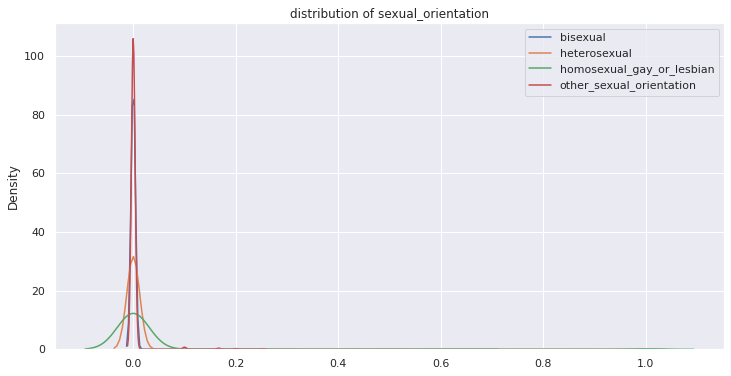

In [ ]:
#distribution of sexual_orientation
toxic_comments = train_df.dropna(axis = 0, how = 'any')
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
toxic_nature_distributions(toxic_comments , features , 'distribution of sexual_orientation')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

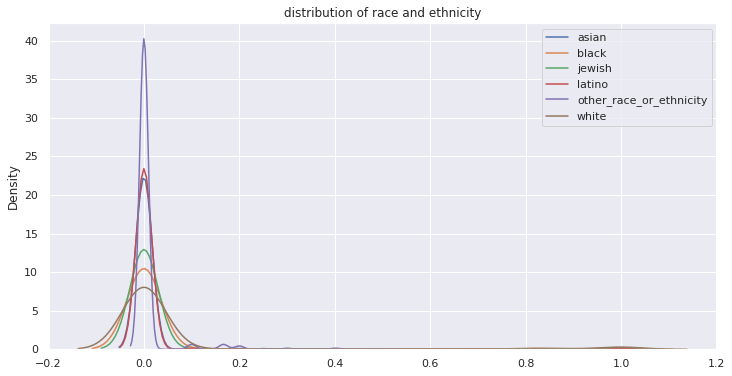

In [ ]:
##distribution of race and ethnicity
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
toxic_nature_distributions(toxic_comments , features , 'distribution of race and ethnicity')



In [ ]:
def user_feedback(feature, title, dataframe, size=1):
  f, ax = plt.subplots(1,1, figsize=(4*size,4))
  cntplot= sns.countplot(dataframe[feature], order = dataframe[feature].value_counts().index[:20], palette='Set3')
  cntplot.set_title('distribution of {}'.format(title))
  plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


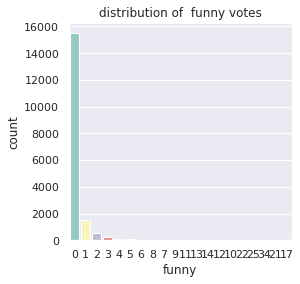

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


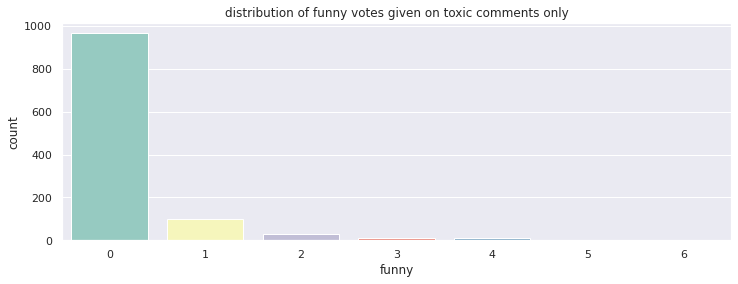

In [ ]:
user_feedback('funny' , ' funny votes' , train_df)
user_feedback('funny', 'funny votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


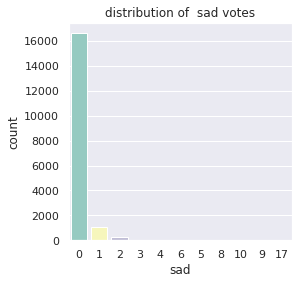

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


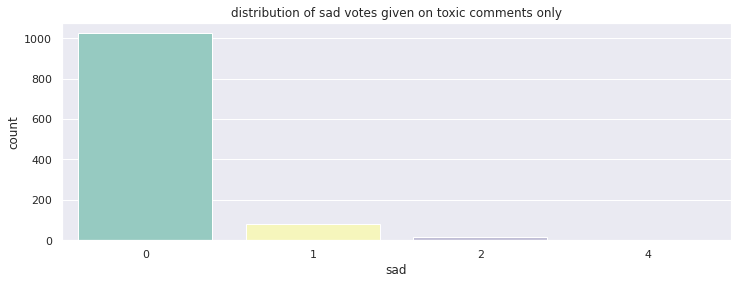

In [ ]:
user_feedback('sad' , ' sad votes' , train_df)
user_feedback('sad', 'sad votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


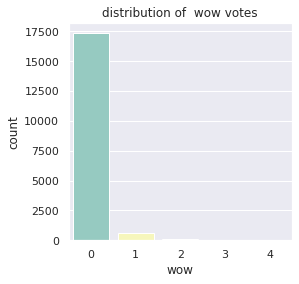

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


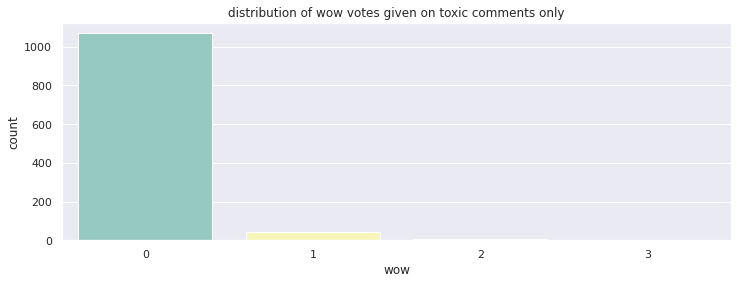

In [ ]:
user_feedback('wow' , ' wow votes' , train_df)
user_feedback('wow', 'wow votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


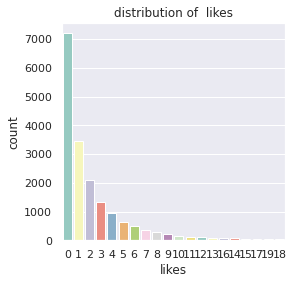

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


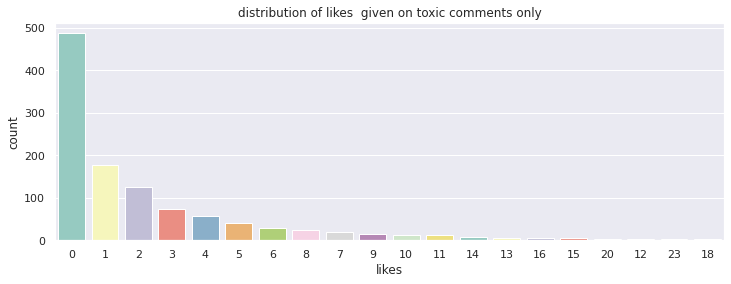

In [ ]:
user_feedback('likes' , ' likes' , train_df)
user_feedback('likes', 'likes  given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


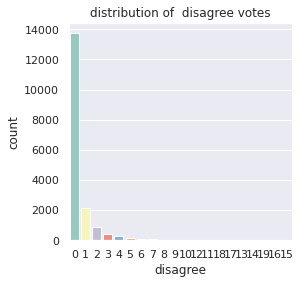

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


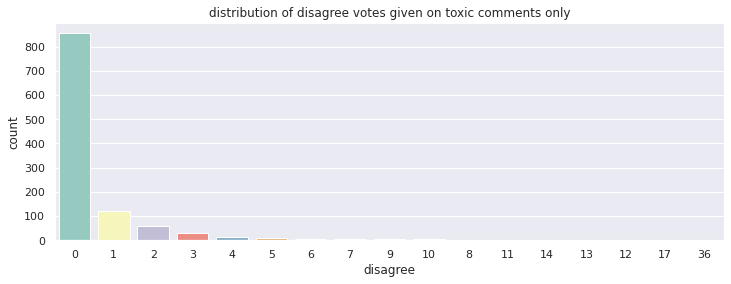

In [ ]:
user_feedback('disagree' , ' disagree votes' , train_df)
user_feedback('disagree', 'disagree votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)


COMMENTS TEXT

In [ ]:
def show_wordcloud(dataframe, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=50,
        max_font_size=40,
        scale=5,
        random_state=1
    ).generate(str(dataframe))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

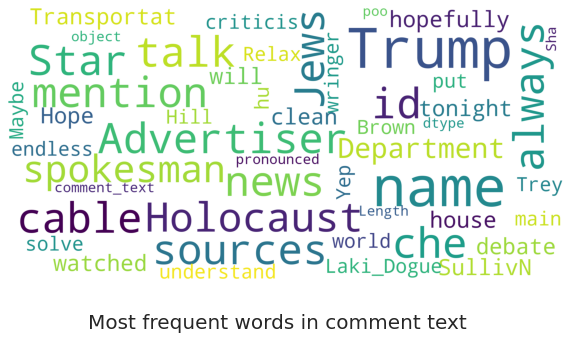

In [ ]:
show_wordcloud(train_df['comment_text'].sample(10000) , title = 'Most frequent words in comment text')

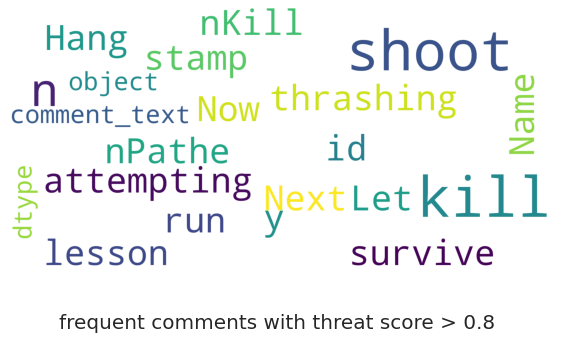

In [ ]:
show_wordcloud(train_df[train_df['threat'] > 0.8]['comment_text'],
               title = 'frequent comments with threat score > 0.8')

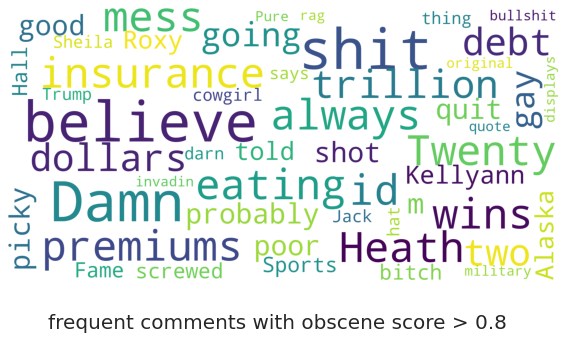

In [ ]:
show_wordcloud(train_df[train_df['obscene'] > 0.8]['comment_text'],
               title = 'frequent comments with obscene score > 0.8')

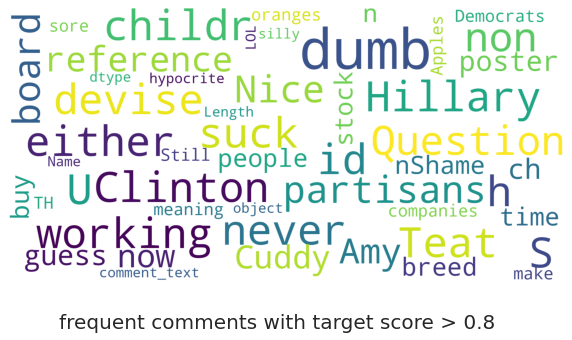

In [ ]:
show_wordcloud(train_df[train_df['target'] > 0.8]['comment_text'],
               title = 'frequent comments with target score > 0.8')

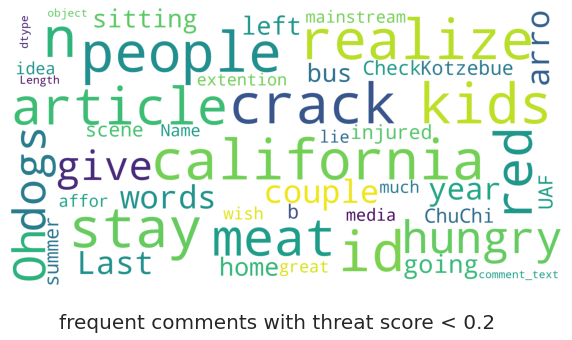

In [ ]:
show_wordcloud(train_df[train_df['threat'] < 0.2]['comment_text'].sample(10000),
               title = 'frequent comments with threat score < 0.2')

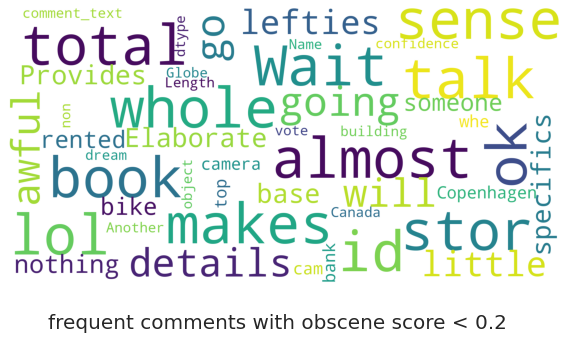

In [ ]:
show_wordcloud(train_df[train_df['obscene'] < 0.2]['comment_text'],
               title = 'frequent comments with obscene score < 0.2')

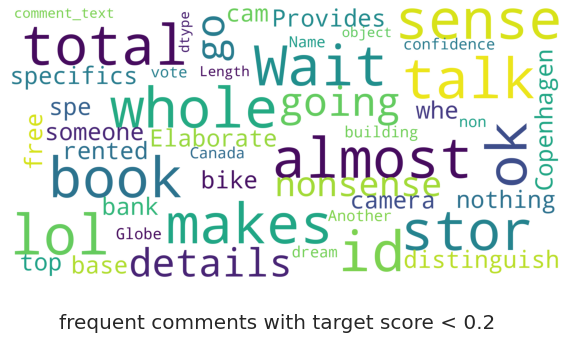

In [ ]:
show_wordcloud(train_df[train_df['target'] < 0.2]['comment_text'],
               title = 'frequent comments with target score < 0.2')

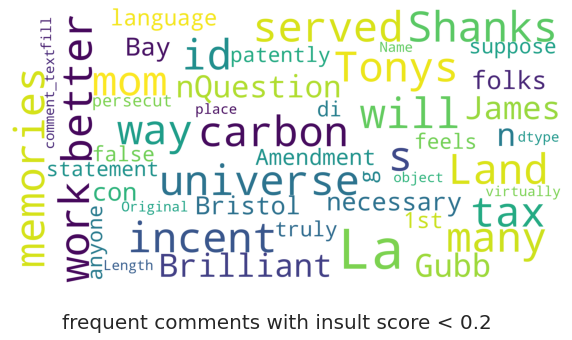

In [ ]:
show_wordcloud(train_df[train_df['insult'] < 0.2]['comment_text'].sample(10000),
               title = 'frequent comments with insult score < 0.2')

In [ ]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
    text_string = text_string.lower() # Convert everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations

    x = text_string.split()
    new_text = []

    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))

    text_string = ' '.join(new_text)
    return text_string

Comment texts are preprocessed

In [ ]:
train_df['preprocessed_comments'] = train_df['comment_text'].apply(preprocess)
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_comments
id,,,,,,,,,,,,,,,,,,,,,
269357,0.0,Wait for the book to get the almost whole stor...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,approved,0,0,0,0,0,0.0,4,4,wait book get almost whole stori hold breath
706524,0.0,And what makes total sense is that he was talk...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,approved,0,0,0,5,0,0.0,4,4,make total sens talk dad
6270881,0.0,lol...ok?,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,approved,0,0,0,1,0,0.0,0,4,lol ok
5670311,0.0,"""""I'm not going to go into the details, but I ...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,approved,0,0,0,5,1,0.0,0,4,go go detail fear strong econom growth pro ene...
593856,0.5,How awful! what will those little lefties do.,0.0,0.0,0.1,0.5,0.0,NaN,NaN,NaN,...,approved,0,0,0,3,0,0.0,0,10,aw littl lefti


In [ ]:
feature = train_df['preprocessed_comments']
output = train_df['target']
# X_train = feature
# y_train = output
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

In [ ]:
## comment text processing in test set
test_df['preprocessed_comments'] = test_df['comment_text'].apply(preprocess)
test_df.head()

,comment_text,preprocessed_comments
id,,
7169480,So according to International Law and Treaties...,accord intern law treati world power nation pr...
7137353,"""Henry Ford did the layoffs following the 1929...",henri ford layoff follow 1929 stock market cra...
7187767,Are you a Catholic? Do you know what the Catho...,cathol know cathol church teach marriag accept...
7174574,Took a bip in FAI. NOT good if that's how the ...,took bip fai good interti set hmmm
7163439,Can you share your sources please?,share sourc pleas


In [ ]:
X_train.shape

(13536,)

In [ ]:
y_train.shape

(13536,)

In [ ]:
X_train.head()

id
1037488    huh anoth guardian faith disagre opposit inter...
5561882    total agre realli howev solv issu larg number ...
526540     slaveri new world prior columbus revisionist n...
5476336    nonsens distinguish free speech hate speech ci...
520872        yeah yeah comrad alreadi know fall racist side
Name: preprocessed_comments, dtype: object

In [ ]:
y_train.head()

id
1037488    0.400000
5561882    0.000000
526540     0.200000
5476336    0.166667
520872     0.000000
Name: target, dtype: float64

In [ ]:
X_test = test_df[['preprocessed_comments']]
X_test.head()

,preprocessed_comments
id,
7169480,accord intern law treati world power nation pr...
7137353,henri ford layoff follow 1929 stock market cra...
7187767,cathol know cathol church teach marriag accept...
7174574,took bip fai good interti set hmmm
7163439,share sourc pleas


In [ ]:
# Saving the files to csv so that we dont need to preprocess again.
X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

MODEL TRAINING

In [ ]:
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')

Term frequency - Inverse Document frequency

In [ ]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train)
tfidf_cv = tfidf_vec.transform(X_cv)
tfidf_test = tfidf_vec.transform(X_test)

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(13536, 30000)
(4513, 30000)
(1, 30000)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

model_params = {

    'decision_tree': {
        'model': DecisionTreeRegressor(),
        'params': {
             'max_depth':[2,5,8,10]
         }
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
             'max_depth':[40,50]
         }
    },
    'knn_regression' : {
        'model': KNeighborsRegressor(),
        'params' : {
             'n_neighbors':[2,5,8,10]
         }
    },
    'svr_regression' : {
        'model': SVR(),
        'params' : {
             'C': [1,5,10],
#              'kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
         }
    }
}

In [ ]:
from sklearn.model_selection import GridSearchCV

scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'],mp['params'], cv=3, return_train_score=True)
    clf.fit(tfidf_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,

    })

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,random_forest,0.371446,{'max_depth': 50}


In [ ]:
from sklearn.model_selection import validation_curve

train_scores, valid_scores = validation_curve(clf.estimator, X_train, y_train, param_name = "max_depth", param_range = np.logspace(-7, 3, 3), cv=3, scoring="r2")

In [ ]:
clf.estimator

RandomForestRegressor()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error

max_depth = [3, 5, 8,10]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for samp in min_samples:
    for d in max_depth:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))

        model = RandomForestRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(tfidf_train, y_train) # Train

        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train, preds) # Calculate error on trainset
        tr_errors.append(err)

        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv, preds) # Calculate error on cv set
        cv_errors.append(err)


        if err < best_error: # Get best model trained
            best_error = err
            best_model = model

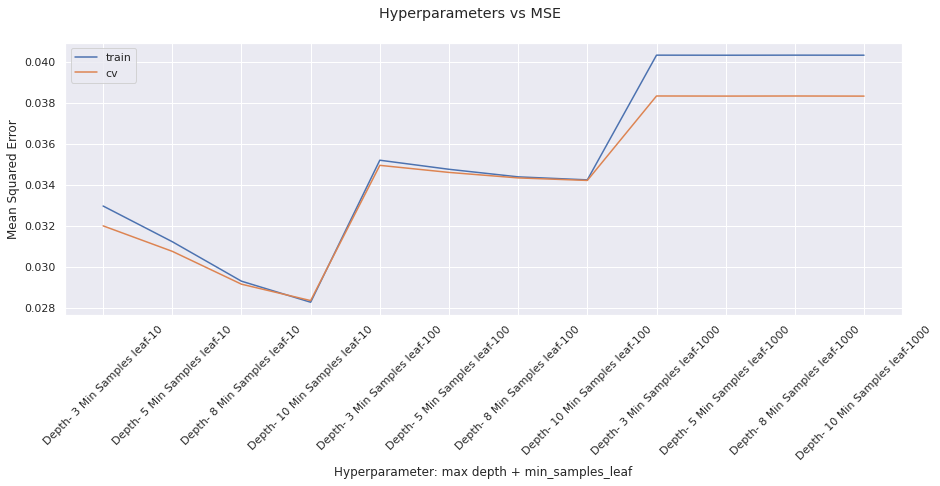

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
# Best models parameters:
best_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'])
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
25312,0.336462
12090,0.199413
18633,0.069485
8241,0.063019
20220,0.060218
14398,0.051073
12025,0.035767
20971,0.031421
10088,0.028877
12110,0.025712


LSTM MODEL

In [ ]:
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Embedding
from keras.utils import pad_sequences

In [ ]:
class LSTMFeaturization:

    def __init__(self):
        self.word_mapping = None
        self.total_words = None



    def build_vocabulary(self, sentences):

        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)


        vocab_dict = dict.fromkeys(vocab, 0)


        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1

        return vocab_dict




    def get_mapping(self, vocab_dict):


        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)

        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')


        df.sort_values(by=['Count'], ascending=False, inplace=True)


        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1

        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)


        dictionary = dict(zip(df['Word'], df['mapping']))

        return dictionary



    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)


    def transform(self, sentences, pad_length = 350):

        whole = list()
        for x in sentences:

            part = list()
            for word in x.split():
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.


        whole = keras.utils.pad_sequences(np.array(whole), maxlen=pad_length)

        return whole

In [ ]:
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train)

In [ ]:
lstm_train = lstmfeat.transform(X_train)
lstm_test = lstmfeat.transform(X_test)
lstm_cv = lstmfeat.transform(X_cv)

<ipython-input-89-5d3141da6b14>:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  whole = keras.utils.pad_sequences(np.array(whole), maxlen=pad_length)


In [ ]:
np.save('lstm_train.npy', lstm_train)
np.save('lstm_cv.npy', lstm_cv)
np.save('lstm_test.npy', lstm_test)

In [ ]:
lstm_train.shape

(13536, 350)

In [ ]:
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
# model.add(Embedding(total_words ,embedding_vecor_length, input_length=350))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(learning_rate=0.0005), metrics=['mse'])


model.build(input_shape=(None,350,1))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 350, 32)           4352      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(lstm_train, y_train, epochs=10,batch_size=512, validation_data=(lstm_cv, y_cv), verbose = 1)

Epoch 1/10
27/27 [==============================] - 37s 1s/step - loss: 0.1676 - mse: 0.1676 - val_loss: 0.1127 - val_mse: 0.1127
Epoch 2/10
27/27 [==============================] - 29s 1s/step - loss: 0.0776 - mse: 0.0776 - val_loss: 0.0476 - val_mse: 0.0476
Epoch 3/10
27/27 [==============================] - 29s 1s/step - loss: 0.0425 - mse: 0.0425 - val_loss: 0.0385 - val_mse: 0.0385
Epoch 4/10
27/27 [==============================] - 31s 1s/step - loss: 0.0404 - mse: 0.0404 - val_loss: 0.0383 - val_mse: 0.0383
Epoch 5/10
27/27 [==============================] - 31s 1s/step - loss: 0.0404 - mse: 0.0404 - val_loss: 0.0383 - val_mse: 0.0383
Epoch 6/10
27/27 [==============================] - 29s 1s/step - loss: 0.0403 - mse: 0.0403 - val_loss: 0.0383 - val_mse: 0.0383
Epoch 7/10
27/27 [==============================] - 29s 1s/step - loss: 0.0403 - mse: 0.0403 - val_loss: 0.0383 - val_mse: 0.0383
Epoch 8/10
27/27 [==============================] - 30s 1s/step - loss: 0.0403 - mse: 0.04

Text(0.5, 1.0, 'Loss Curves')

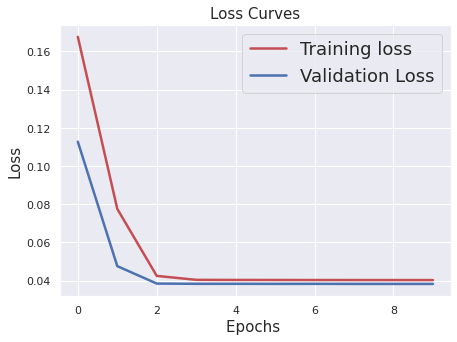

In [ ]:
plt.figure(figsize=[7,5])
plt.plot(history.history['loss'],'r',linewidth=2.5)
plt.plot(history.history['val_loss'],'b',linewidth=2.5)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title('Loss Curves',fontsize=15)

6) We can observe that Random Forest has outperformed other algorithms with minimal loss.
We can still use more complex neural network approaches for further analysis.
```
# This is formatted as code
```

